**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


C:\Users\VARSHINI.M\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 **Environment Setup**

In [2]:
np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

nltk.download('stopwords')
nltk.download('wordnet')

Using device: cpu


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VARSHINI.M\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\VARSHINI.M\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Load the Dataset**

In [3]:
df = pd.read_csv(r"C:\Users\VARSHINI.M\OneDrive\Desktop\7th sem\interdisclipinary\Datasets\Sentiment Analysis for Financial News\all-data.csv", encoding='latin-1', header=None)
df.columns = ['sentiment', 'text']

**Normalize sentiment labels**

In [4]:
sentiment_map = {'negative': -1, 'neutral': 0, 'positive': 1}
df['sentiment'] = df['sentiment'].map(sentiment_map)
df.dropna(subset=['sentiment'], inplace=True)
df['sentiment'] = df['sentiment'].astype(int)

label_text_map = {-1: "Negative", 0: "Neutral", 1: "Positive"}

print("Original Class Distribution:")
print(df['sentiment'].map(label_text_map).value_counts(), "\n")



Original Class Distribution:
sentiment
Neutral     2879
Positive    1363
Negative     604
Name: count, dtype: int64 



**HANDLE CLASS IMBALANCE (Oversampling)**

In [5]:
df_neg = df[df['sentiment'] == -1]
df_neu = df[df['sentiment'] == 0]
df_pos = df[df['sentiment'] == 1]

max_size = max(len(df_neg), len(df_neu), len(df_pos))
print(f"Oversampling minority classes to match {max_size} samples per class...\n")

df_neg_over = resample(df_neg, replace=True, n_samples=max_size, random_state=42)
df_neu_over = resample(df_neu, replace=True, n_samples=max_size, random_state=42)
df_pos_over = resample(df_pos, replace=True, n_samples=max_size, random_state=42)

df_balanced = pd.concat([df_neg_over, df_neu_over, df_pos_over])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced Class Distribution:")
print(df_balanced['sentiment'].map(label_text_map).value_counts(), "\n")

Oversampling minority classes to match 2879 samples per class...

Balanced Class Distribution:
sentiment
Negative    2879
Positive    2879
Neutral     2879
Name: count, dtype: int64 



**Text preprocessing**

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    return " ".join(tokens)

df_balanced['clean_text'] = df_balanced['text'].astype(str).apply(clean_text)


**Train–Validation–Test Split**

In [7]:

X_train, X_temp, y_train, y_temp = train_test_split(
    df_balanced['clean_text'], df_balanced['sentiment'],
    test_size=0.3, stratify=df_balanced['sentiment'], random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f" Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")


 Train: 6045 | Val: 1296 | Test: 1296


**Tokenization (Using FinBERT)**

In [8]:
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")

def encode_texts(texts, max_len=128):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )

train_enc = encode_texts(X_train)
val_enc = encode_texts(X_val)
test_enc = encode_texts(X_test)

# Label mappings
sentiment_to_idx = {-1: 0, 0: 1, 1: 2}
idx_to_sentiment = {0: -1, 1: 0, 2: 1}
idx_to_label = {0: "Negative", 1: "Neutral", 2: "Positive"}

y_train_idx = y_train.map(sentiment_to_idx)
y_val_idx = y_val.map(sentiment_to_idx)
y_test_idx = y_test.map(sentiment_to_idx)

**Custom Dataset Wrapper**

In [9]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

train_ds = SentimentDataset(train_enc, torch.tensor(y_train_idx.values))
val_ds   = SentimentDataset(val_enc, torch.tensor(y_val_idx.values))
test_ds  = SentimentDataset(test_enc, torch.tensor(y_test_idx.values))

**Model Architecture (FinBERT + LSTM)**

In [10]:
class FinBERT_LSTM(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=3):
        super(FinBERT_LSTM, self).__init__()
        self.bert = BertModel.from_pretrained("ProsusAI/finbert")
        self.lstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # Freeze FinBERT layers
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        lstm_out, _ = self.lstm(bert_output.last_hidden_state)
        pooled = torch.mean(lstm_out, dim=1)
        out = self.dropout(pooled)
        return self.fc(out)

model = FinBERT_LSTM().to(device)

**Training, Test & Validation Setup**

In [11]:
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False)

# Helper function to compute accuracy & loss
def compute_accuracy_and_loss(loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in loader:
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(ids, mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total, total_loss / len(loader)

**Training Loop**

In [12]:
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_train_loss, correct_train, total_train = 0, 0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad()
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(ids, mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_loss = total_train_loss / len(train_loader)
    val_acc, val_loss = compute_accuracy_and_loss(val_loader)
    test_acc, test_loss = compute_accuracy_and_loss(test_loader)

    print(f"\n EPOCH {epoch+1}/{EPOCHS} SUMMARY")
    print(f"Train → Acc: {train_acc*100:.2f}% | Loss: {train_loss:.4f}")
    print(f"Val   → Acc: {val_acc*100:.2f}% | Loss: {val_loss:.4f}")
    print(f"Test  → Acc: {test_acc*100:.2f}% | Loss: {test_loss:.4f}")
    print("-"*60)


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████| 378/378 [12:48<00:00,  2.03s/it]



 EPOCH 1/10 SUMMARY
Train → Acc: 64.81% | Loss: 0.8784
Val   → Acc: 74.54% | Loss: 0.6810
Test  → Acc: 75.23% | Loss: 0.6770
------------------------------------------------------------


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████| 378/378 [12:21<00:00,  1.96s/it]



 EPOCH 2/10 SUMMARY
Train → Acc: 73.53% | Loss: 0.6668
Val   → Acc: 76.23% | Loss: 0.5897
Test  → Acc: 76.93% | Loss: 0.5922
------------------------------------------------------------


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████| 378/378 [13:21<00:00,  2.12s/it]



 EPOCH 3/10 SUMMARY
Train → Acc: 74.43% | Loss: 0.6206
Val   → Acc: 75.93% | Loss: 0.5677
Test  → Acc: 76.47% | Loss: 0.5710
------------------------------------------------------------


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████| 378/378 [10:54<00:00,  1.73s/it]



 EPOCH 4/10 SUMMARY
Train → Acc: 75.40% | Loss: 0.6001
Val   → Acc: 76.77% | Loss: 0.5523
Test  → Acc: 76.85% | Loss: 0.5538
------------------------------------------------------------


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████| 378/378 [12:29<00:00,  1.98s/it]



 EPOCH 5/10 SUMMARY
Train → Acc: 75.53% | Loss: 0.5858
Val   → Acc: 77.47% | Loss: 0.5388
Test  → Acc: 77.31% | Loss: 0.5390
------------------------------------------------------------


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████| 378/378 [10:26<00:00,  1.66s/it]



 EPOCH 6/10 SUMMARY
Train → Acc: 76.54% | Loss: 0.5732
Val   → Acc: 78.24% | Loss: 0.5265
Test  → Acc: 78.16% | Loss: 0.5252
------------------------------------------------------------


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████| 378/378 [09:54<00:00,  1.57s/it]



 EPOCH 7/10 SUMMARY
Train → Acc: 76.54% | Loss: 0.5659
Val   → Acc: 79.24% | Loss: 0.5170
Test  → Acc: 78.47% | Loss: 0.5135
------------------------------------------------------------


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████| 378/378 [09:51<00:00,  1.57s/it]



 EPOCH 8/10 SUMMARY
Train → Acc: 77.60% | Loss: 0.5470
Val   → Acc: 79.55% | Loss: 0.5021
Test  → Acc: 78.86% | Loss: 0.4992
------------------------------------------------------------


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████| 378/378 [09:49<00:00,  1.56s/it]



 EPOCH 9/10 SUMMARY
Train → Acc: 78.23% | Loss: 0.5354
Val   → Acc: 80.02% | Loss: 0.4886
Test  → Acc: 79.40% | Loss: 0.4881
------------------------------------------------------------


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 378/378 [10:11<00:00,  1.62s/it]



 EPOCH 10/10 SUMMARY
Train → Acc: 78.99% | Loss: 0.5156
Val   → Acc: 80.56% | Loss: 0.4839
Test  → Acc: 80.79% | Loss: 0.4758
------------------------------------------------------------


**Final Evaluation**

In [13]:
def evaluate_model(model, dataset, y_true_idx):
    loader = DataLoader(dataset, batch_size=32)
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in loader:
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            outputs = model(ids, mask)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
    y_true_text = [idx_to_label[i] for i in y_true_idx]
    y_pred_text = [idx_to_label[i] for i in preds]
    print("\n FINAL TEST REPORT:")
    print(classification_report(y_true_text, y_pred_text))
    return accuracy_score(y_true_idx, preds)

final_acc = evaluate_model(model, test_ds, y_test_idx)
print(f" Final Test Accuracy: {final_acc*100:.2f}%")



 FINAL TEST REPORT:
              precision    recall  f1-score   support

    Negative       0.85      0.90      0.87       432
     Neutral       0.80      0.75      0.78       432
    Positive       0.77      0.78      0.77       432

    accuracy                           0.81      1296
   macro avg       0.81      0.81      0.81      1296
weighted avg       0.81      0.81      0.81      1296

 Final Test Accuracy: 80.79%


**SAVE TRAINED MODEL**

In [14]:
torch.save(model.state_dict(), "finbert_lstm_balanced_model.pth")
print("Model saved as 'finbert_lstm_balanced_model.pth'")

💾 Model saved as 'finbert_lstm_balanced_model.pth'


**CONFUSION MATRIX**

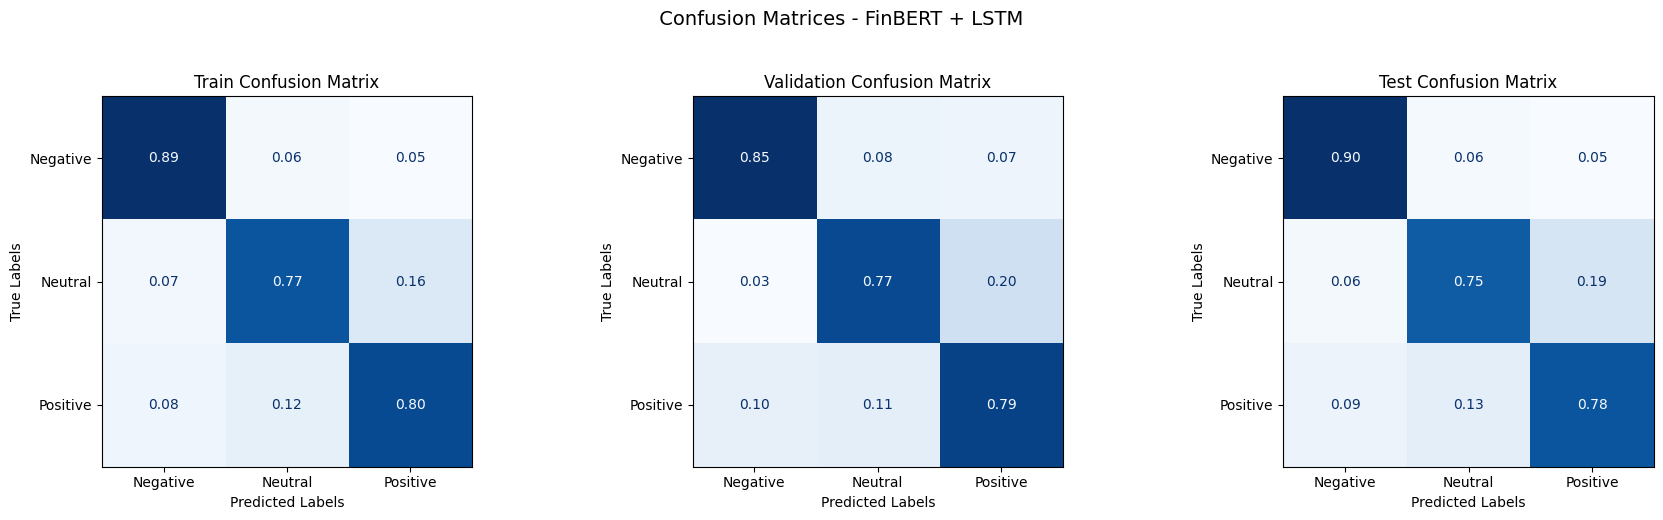

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix_all(model, datasets, true_labels, set_names, normalize=False):
    """Plots confusion matrices for multiple datasets (Train/Val/Test)."""
    model.eval()
    num_sets = len(datasets)
    fig, axes = plt.subplots(1, num_sets, figsize=(6*num_sets, 5))
    if num_sets == 1:
        axes = [axes]

    for i, (dataset, y_true, name) in enumerate(zip(datasets, true_labels, set_names)):
        loader = DataLoader(dataset, batch_size=32)
        preds = []
        with torch.no_grad():
            for batch in loader:
                ids = batch['input_ids'].to(device)
                mask = batch['attention_mask'].to(device)
                outputs = model(ids, mask)
                preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())

        cm = confusion_matrix(y_true, preds, normalize='true' if normalize else None)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
        disp.plot(ax=axes[i], cmap="Blues", values_format=".2f" if normalize else "d", colorbar=False)
        axes[i].set_title(f"{name} Confusion Matrix")
        axes[i].set_xlabel("Predicted Labels")
        axes[i].set_ylabel("True Labels")

    plt.suptitle(" Confusion Matrices - FinBERT + LSTM", fontsize=14, y=1.03)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix_all(
    model,
    datasets=[train_ds, val_ds, test_ds],
    true_labels=[y_train_idx, y_val_idx, y_test_idx],
    set_names=["Train", "Validation", "Test"],
    normalize=True
)


**OVERALL CONFUSION MATRIX**

<Figure size 600x500 with 0 Axes>

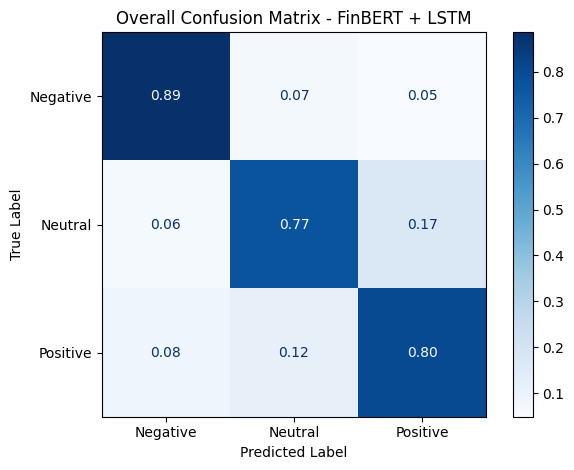


 Classification Report (Overall):
              precision    recall  f1-score   support

    Negative       0.86      0.89      0.87      2879
     Neutral       0.81      0.77      0.79      2879
    Positive       0.78      0.80      0.79      2879

    accuracy                           0.82      8637
   macro avg       0.82      0.82      0.82      8637
weighted avg       0.82      0.82      0.82      8637



In [17]:
def plot_overall_confusion_matrix(model, datasets, true_labels, normalize=False):
    """Plots combined confusion matrix for Train + Val + Test datasets."""
    model.eval()
    all_preds, all_true = [], []
    for dataset, y_true in zip(datasets, true_labels):
        loader = DataLoader(dataset, batch_size=32)
        preds = []
        with torch.no_grad():
            for batch in loader:
                ids = batch['input_ids'].to(device)
                mask = batch['attention_mask'].to(device)
                outputs = model(ids, mask)
                preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_preds.extend(preds)
        all_true.extend(y_true)

    cm = confusion_matrix(all_true, all_preds, normalize='true' if normalize else None)
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
    disp.plot(cmap="Blues", values_format=".2f" if normalize else "d")
    plt.title("Overall Confusion Matrix - FinBERT + LSTM")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    print("\n Classification Report (Overall):")
    print(classification_report(all_true, all_preds, target_names=["Negative", "Neutral", "Positive"]))

plot_overall_confusion_matrix(
    model,
    datasets=[train_ds, val_ds, test_ds],
    true_labels=[y_train_idx, y_val_idx, y_test_idx],
    normalize=True
)

**REAL-TIME PREDICTION**

In [18]:
def predict_sentiment(sentence):
    model.eval()
    cleaned = clean_text(sentence)
    encoded = tokenizer(cleaned, return_tensors='pt', truncation=True, padding=True, max_length=128)
    input_ids = encoded['input_ids'].to(device)
    attn_mask = encoded['attention_mask'].to(device)
    with torch.no_grad():
        logits = model(input_ids, attn_mask)
        pred = torch.argmax(logits, dim=1).item()
    sentiment_val = idx_to_sentiment[pred]
    return f"{idx_to_label[pred]} ({sentiment_val})"

print("\n💬 Example Predictions:")
examples = [
    "The company reported record profits this quarter!",
    "The stock market is unstable due to new regulations.",
    "Investors are unsure about the future of this firm."
]
for s in examples:
    print(f"{s} → {predict_sentiment(s)}")



💬 Example Predictions:
The company reported record profits this quarter! → Positive (1)
The stock market is unstable due to new regulations. → Negative (-1)
Investors are unsure about the future of this firm. → Neutral (0)


 **LOAD SAVED MODEL & PREDICT IN REAL-TIME**

In [ ]:
# Load the saved model before prediction
MODEL_PATH = "finbert_lstm_balanced_model.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()
print(f"Loaded model from: {MODEL_PATH}")

#  Define Prediction Function
def predict_sentiment(sentence):
    model.eval()
    cleaned = clean_text(sentence)
    encoded = tokenizer(cleaned, return_tensors='pt', truncation=True, padding=True, max_length=128)
    input_ids = encoded['input_ids'].to(device)
    attn_mask = encoded['attention_mask'].to(device)
    with torch.no_grad():
        logits = model(input_ids, attn_mask)
        pred = torch.argmax(logits, dim=1).item()
    sentiment_val = idx_to_sentiment[pred]
    return f"{idx_to_label[pred]} ({sentiment_val})"

# Example Predictions
print("\n💬 Example Predictions:")
examples = [
    "The company reported record profits this quarter! Sales exceeded expectations across all regions.",
    "The stock market is unstable due to new regulations. Many investors are pulling back from risky assets.",
    "Investors are unsure about the future of this firm. Its recent management changes raised serious concerns.",
    "The merger between the two banks was well received by analysts. Shares rose sharply after the announcement.",
    "Weak consumer demand continues to hurt quarterly earnings. The firm announced potential layoffs next month.",
    "The government’s new tax incentives boosted corporate confidence. Economic growth projections were revised upward.",
    "Rising inflation has reduced purchasing power. Retail stocks dropped amid declining customer sentiment.",
    "The company’s innovative AI product attracted major investors. Market experts predict strong revenue growth."
]
for s in examples:
    print(f"{s} → {predict_sentiment(s)}")


# **Modelwithout pre trained model(Finbert)**

**Import libraries**

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils import resample
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
import warnings
warnings.filterwarnings("ignore")


**Environment setup**

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Using device:", device)

nltk.download('stopwords')
nltk.download('wordnet')


**Load Dataset**

In [ ]:
df = pd.read_csv("/content/all-data.csv", encoding='latin-1', header=None)
df.columns = ['sentiment', 'text']


**Normalize sentiment labels**

In [ ]:
sentiment_map = {'negative': -1, 'neutral': 0, 'positive': 1}
df['sentiment'] = df['sentiment'].map(sentiment_map)
df.dropna(subset=['sentiment'], inplace=True)
df['sentiment'] = df['sentiment'].astype(int)

label_text_map = {-1: "Negative", 0: "Neutral", 1: "Positive"}

print(" Original Class Distribution:")
print(df['sentiment'].map(label_text_map).value_counts(), "\n")


 **Handle Imbalance (Oversampling)**

In [ ]:

df_neg = df[df['sentiment'] == -1]
df_neu = df[df['sentiment'] == 0]
df_pos = df[df['sentiment'] == 1]

max_size = max(len(df_neg), len(df_neu), len(df_pos))
print(f" Oversampling minority classes to match {max_size} samples per class...\n")

df_neg_over = resample(df_neg, replace=True, n_samples=max_size, random_state=42)
df_neu_over = resample(df_neu, replace=True, n_samples=max_size, random_state=42)
df_pos_over = resample(df_pos, replace=True, n_samples=max_size, random_state=42)

df_balanced = pd.concat([df_neg_over, df_neu_over, df_pos_over])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(" Balanced Class Distribution:")
print(df_balanced['sentiment'].map(label_text_map).value_counts(), "\n")


**Text Preprocessing**

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    return tokens

df_balanced['tokens'] = df_balanced['text'].astype(str).apply(clean_text)



**Vocabulary Building**

In [ ]:

from collections import Counter

all_tokens = [token for tokens in df_balanced['tokens'] for token in tokens]
vocab = {word: i+2 for i, (word, _) in enumerate(Counter(all_tokens).most_common())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

vocab_size = len(vocab)
print(f" Vocabulary size: {vocab_size}")

def encode_tokens(tokens, max_len=50):
    ids = [vocab.get(t, 1) for t in tokens]
    if len(ids) > max_len:
        ids = ids[:max_len]
    return torch.tensor(ids)


**Data Split**

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    df_balanced['tokens'], df_balanced['sentiment'],
    test_size=0.3, stratify=df_balanced['sentiment'], random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f" Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

sentiment_to_idx = {-1: 0, 0: 1, 1: 2}
idx_to_label = {0: "Negative", 1: "Neutral", 2: "Positive"}

y_train_idx = y_train.map(sentiment_to_idx)
y_val_idx = y_val.map(sentiment_to_idx)
y_test_idx = y_test.map(sentiment_to_idx)

**Dataset & Dataloader**

In [ ]:
class LSTMDataset(Dataset):
    def __init__(self, texts, labels, max_len=50):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        encoded = encode_tokens(self.texts.iloc[idx], self.max_len)
        return encoded, torch.tensor(self.labels.iloc[idx])

def collate_fn(batch):
    texts, labels = zip(*batch)
    padded = pad_sequence(texts, batch_first=True, padding_value=0)
    return padded, torch.tensor(labels)

train_ds = LSTMDataset(X_train, y_train_idx)
val_ds = LSTMDataset(X_val, y_val_idx)
test_ds = LSTMDataset(X_test, y_test_idx)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

**LSTM Model**

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=3):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        pooled = torch.mean(lstm_out, dim=1)
        out = self.dropout(pooled)
        return self.fc(out)

model = LSTMClassifier(vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

**Training and validation**

In [ ]:
def compute_accuracy_and_loss(loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total, total_loss / len(loader)

EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_train_loss, correct_train, total_train = 0, 0, 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_train += (preds == y).sum().item()
        total_train += y.size(0)

    train_acc = correct_train / total_train
    train_loss = total_train_loss / len(train_loader)
    val_acc, val_loss = compute_accuracy_and_loss(val_loader)
    test_acc, test_loss = compute_accuracy_and_loss(test_loader)

    print(f"\n EPOCH {epoch+1}/{EPOCHS} SUMMARY")
    print(f"Train  → Acc: {train_acc*100:.2f}% | Loss: {train_loss:.4f}")
    print(f"Val    → Acc: {val_acc*100:.2f}% | Loss: {val_loss:.4f}")
    print(f"Test   → Acc: {test_acc*100:.2f}% | Loss: {test_loss:.4f}")
    print("-"*60)


**Final Evaluation**

In [ ]:
def evaluate_model(model, loader, y_true_idx):
    model.eval()
    preds = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            outputs = model(x)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
    y_true_text = [idx_to_label[i] for i in y_true_idx]
    y_pred_text = [idx_to_label[i] for i in preds]
    print("\nFINAL TEST REPORT:")
    print(classification_report(y_true_text, y_pred_text))
    print("\n CONFUSION MATRIX:")
    print(confusion_matrix(y_true_text, y_pred_text))
    return accuracy_score(y_true_idx, preds)

final_acc = evaluate_model(model, test_loader, y_test_idx)
print(f"✅ Final Test Accuracy: {final_acc*100:.2f}%")


**Plots**

In [ ]:
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_acc"], marker='o', label="Train Accuracy")
plt.plot(epochs_range, history["val_acc"], marker='o', label="Validation Accuracy")
plt.plot(epochs_range, history["test_acc"], marker='o', label="Test Accuracy")
plt.title(" Model Accuracy (Train / Val / Test)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_loss"], marker='o', label="Train Loss")
plt.plot(epochs_range, history["val_loss"], marker='o', label="Validation Loss")
plt.plot(epochs_range, history["test_loss"], marker='o', label="Test Loss")
plt.title(" Model Loss (Train / Val / Test)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Confusion Matrix**

In [ ]:

def plot_confusion_matrix_all(model, datasets, true_labels, set_names, normalize=False):
    """Plots confusion matrices for multiple datasets (Train/Val/Test)."""
    model.eval()
    num_sets = len(datasets)
    fig, axes = plt.subplots(1, num_sets, figsize=(6*num_sets, 5))
    if num_sets == 1:
        axes = [axes]

    for i, (dataset, y_true, name) in enumerate(zip(datasets, true_labels, set_names)):
        loader = DataLoader(dataset, batch_size=32)
        preds = []
        with torch.no_grad():
            for batch in loader:
                ids = batch['input_ids'].to(device)
                mask = batch['attention_mask'].to(device)
                outputs = model(ids, mask)
                preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())

        cm = confusion_matrix(y_true, preds, normalize='true' if normalize else None)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
        disp.plot(ax=axes[i], cmap="Blues", values_format=".2f" if normalize else "d", colorbar=False)
        axes[i].set_title(f"{name} Confusion Matrix")
        axes[i].set_xlabel("Predicted Labels")
        axes[i].set_ylabel("True Labels")

    plt.suptitle(" Confusion Matrices - FinBERT + LSTM", fontsize=14, y=1.03)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix_all(
    model,
    datasets=[train_ds, val_ds, test_ds],
    true_labels=[y_train_idx, y_val_idx, y_test_idx],
    set_names=["Train", "Validation", "Test"],
    normalize=True
)


**Overall confusion matrix**

In [ ]:
def plot_overall_confusion_matrix(model, datasets, true_labels, normalize=False):
    """Plots combined confusion matrix for Train + Val + Test datasets."""
    model.eval()
    all_preds, all_true = [], []
    for dataset, y_true in zip(datasets, true_labels):
        loader = DataLoader(dataset, batch_size=32)
        preds = []
        with torch.no_grad():
            for batch in loader:
                ids = batch['input_ids'].to(device)
                mask = batch['attention_mask'].to(device)
                outputs = model(ids, mask)
                preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_preds.extend(preds)
        all_true.extend(y_true)

    cm = confusion_matrix(all_true, all_preds, normalize='true' if normalize else None)
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
    disp.plot(cmap="Blues", values_format=".2f" if normalize else "d")
    plt.title(" Overall Confusion Matrix - FinBERT + LSTM")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    print("\n Classification Report (Overall):")
    print(classification_report(all_true, all_preds, target_names=["Negative", "Neutral", "Positive"]))

plot_overall_confusion_matrix(
    model,
    datasets=[train_ds, val_ds, test_ds],
    true_labels=[y_train_idx, y_val_idx, y_test_idx],
    normalize=True
)

**Save the trained model**

In [ ]:
torch.save(model.state_dict(), "lstm_balanced_model.pth")
print(" Model saved as 'lstm_balanced_model.pth'")

**Real-Time Prediction**

In [ ]:
def predict_sentiment(sentence):
    model.eval()
    tokens = clean_text(sentence)
    encoded = encode_tokens(tokens).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(encoded)
        pred = torch.argmax(logits, dim=1).item()
    return f"{idx_to_label[pred]} ({list(sentiment_to_idx.keys())[list(sentiment_to_idx.values()).index(pred)]})"

print("\n Example Predictions:")
examples = [
    "The company reported record profits this quarter!",
    "The stock market is unstable due to new regulations.",
    "Investors are unsure about the future of this firm."
]
for s in examples:
    print(f"{s} → {predict_sentiment(s)}")

**Load the saved model and predict**

In [ ]:
# Load the saved model before prediction
MODEL_PATH = "finbert_lstm_balanced_model.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()
print(f"Loaded model from: {MODEL_PATH}")

#  Define Prediction Function
def predict_sentiment(sentence):
    model.eval()
    cleaned = clean_text(sentence)
    encoded = tokenizer(cleaned, return_tensors='pt', truncation=True, padding=True, max_length=128)
    input_ids = encoded['input_ids'].to(device)
    attn_mask = encoded['attention_mask'].to(device)
    with torch.no_grad():
        logits = model(input_ids, attn_mask)
        pred = torch.argmax(logits, dim=1).item()
    sentiment_val = idx_to_sentiment[pred]
    return f"{idx_to_label[pred]} ({sentiment_val})"

# Example Predictions
print("\n Example Predictions:")
examples = [
    "The company reported record profits this quarter! Sales exceeded expectations across all regions.",
    "The stock market is unstable due to new regulations. Many investors are pulling back from risky assets.",
    "Investors are unsure about the future of this firm. Its recent management changes raised serious concerns.",
    "The merger between the two banks was well received by analysts. Shares rose sharply after the announcement.",
    "Weak consumer demand continues to hurt quarterly earnings. The firm announced potential layoffs next month.",
    "The government’s new tax incentives boosted corporate confidence. Economic growth projections were revised upward.",
    "Rising inflation has reduced purchasing power. Retail stocks dropped amid declining customer sentiment.",
    "The company’s innovative AI product attracted major investors. Market experts predict strong revenue growth."
]
for s in examples:
    print(f"{s} → {predict_sentiment(s)}")
